## Categorising countries

### Data Source

The data used in this task was orginally sourced from Help.NGO. This international non-governmental organisation specialises in emergency response, preparedness, and risk mitigation.  

### Dataset Attributes
- country: name of the country
- child_mort: death of children under 5 years of age per 1000 live births
- exports: exports of goods and services per capita. Given as a percentage of the GDP per capita
- health: total health spending per capita. Given as a percentage of GDP per capita
- imports: imports of goods and services per capita. Given as a percentage of the GDP per capita
- income: net income per person
- inflation: the measurement of the annual growth rate of the Total GDP
- life_expec: the average number of years a new born child would live if the current mortality patterns remain the same
- total_fer: the number of children that would be born to each woman if the current age-fertility rates remains the same
- gdpp: the GDP per capita. Calculated as the Total GDP divided by the total population.

## Objective  
To group countries using socio-economic and health factors to determine the development status of the country.

In [ ]:
# Import libraries
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)
import os

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# Random state seed
rseed = 42

## Load and explore data

In [ ]:
# Import the dataset

from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()
gc = gspread.authorize(creds)

from google.colab import drive
drive.mount('/content/drive')

worksheet = gc.open("Country-data").sheet1
from gspread_dataframe import get_as_dataframe

df = get_as_dataframe(worksheet)

Mounted at /content/drive


In [ ]:
# Check the shape

df.shape

(167, 10)

In [ ]:
# Check datatypes & counts

df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    float64
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    float64
dtypes: float64(9), object(1)
memory usage: 14.4+ KB


In [ ]:
# Get descriptive statistics

df.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,41.108976,6.815689,46.890215,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,27.412010,2.746837,24.209589,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,0.109000,1.810000,0.065900,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,23.800000,4.920000,30.200000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,35.000000,6.320000,43.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,51.350000,8.600000,58.750000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,200.000000,17.900000,174.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


In [ ]:
# Identify any missing data

df.isnull().sum()

,0
country,0
child_mort,0
exports,0
health,0
imports,0
income,0
inflation,0
life_expec,0
total_fer,0
gdpp,0


## Preprocessing and Feature Selection

In [ ]:
# Drop any non-numeric features (columns)

df_numeric = df.select_dtypes(include=['number'])


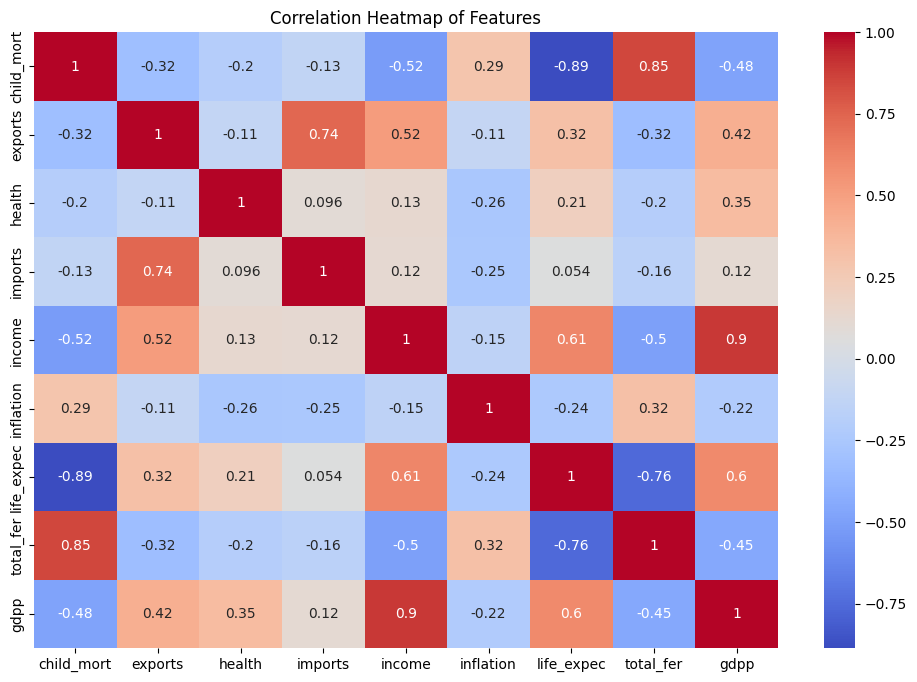

In [ ]:
# Create a correlation map of features to explore relationships between features
# Hint: Explore seaborn heatmap

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))
sns.heatmap(df_numeric.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap of Features")
plt.show()

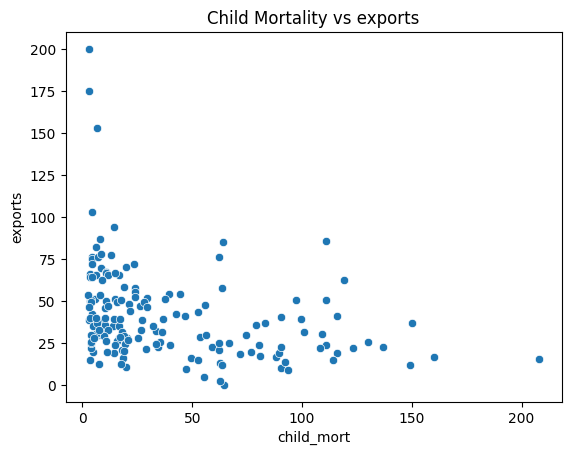

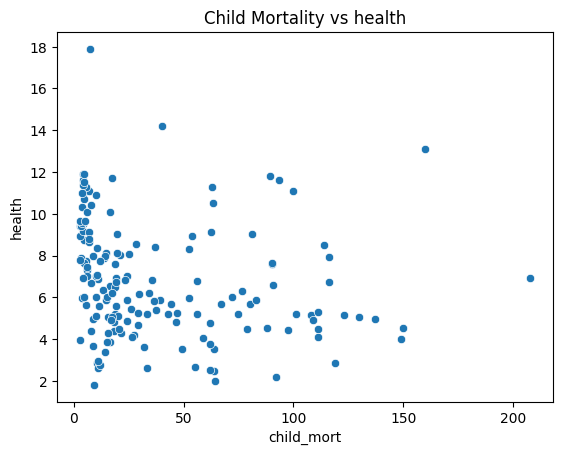

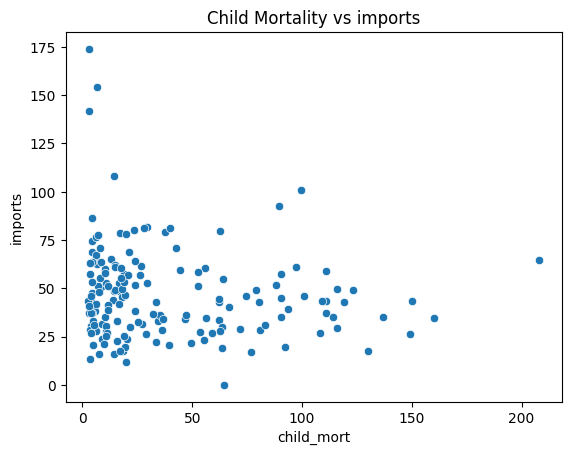

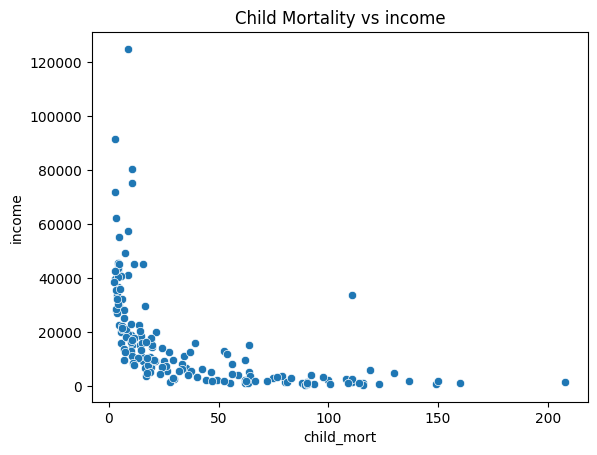

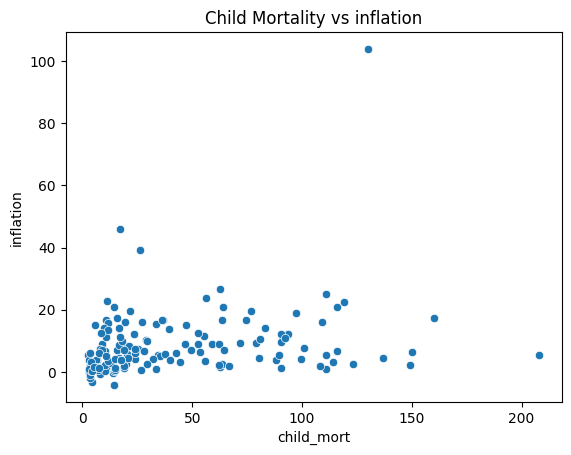

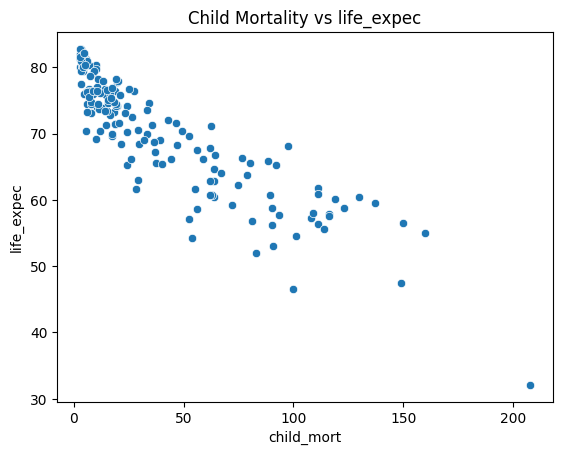

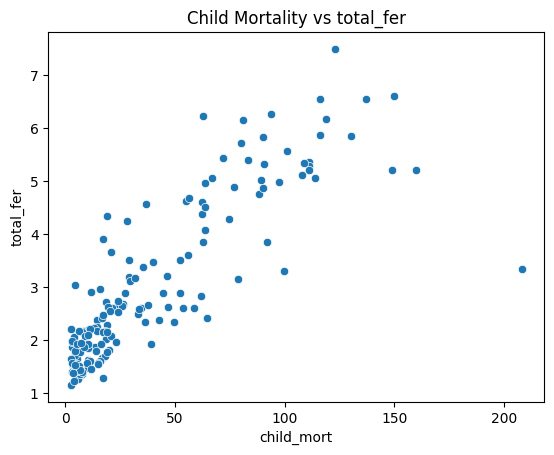

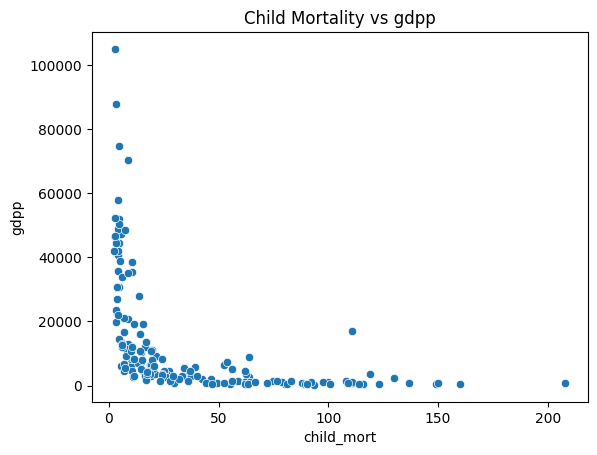

In [ ]:
# Explore the continuous independent features against child_mort using scatter plots.

for column in df_numeric.columns:
    if column != 'child_mort':
        plt.figure()
        sns.scatterplot(data=df_numeric, x='child_mort', y=column)
        plt.title(f'Child Mortality vs {column}')
        plt.show()

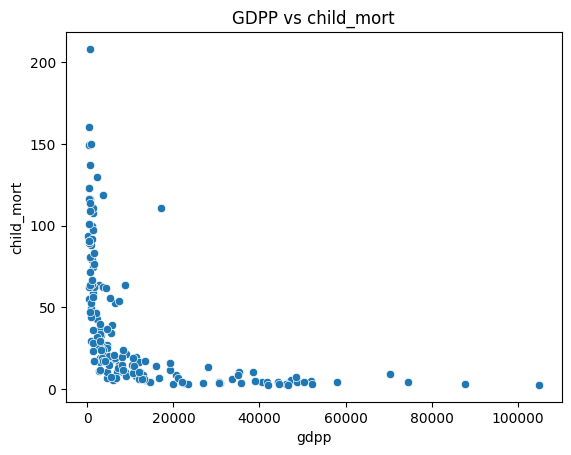

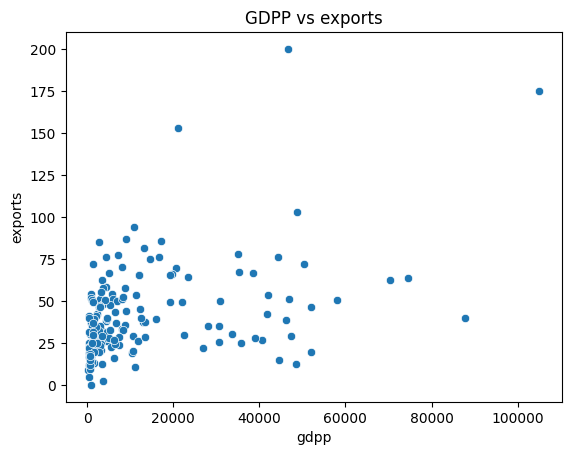

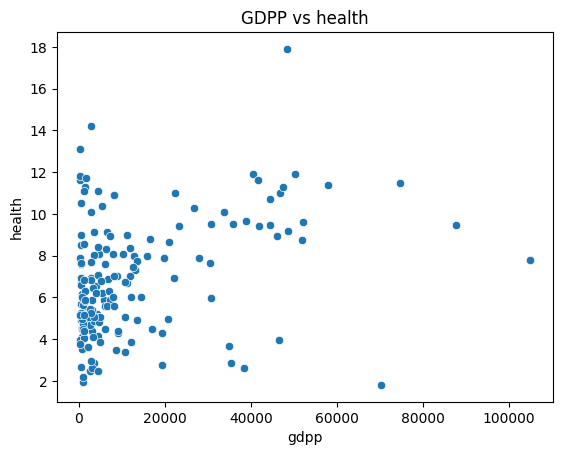

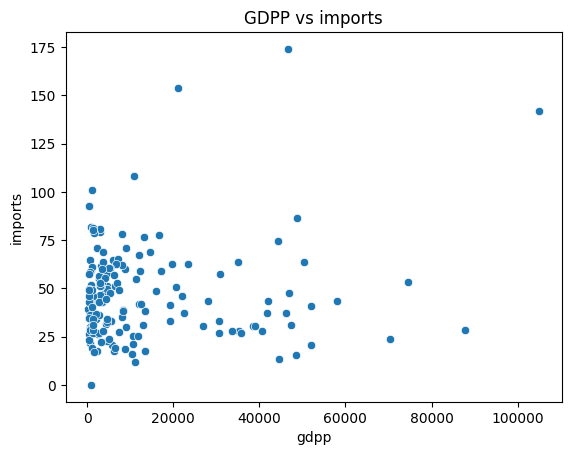

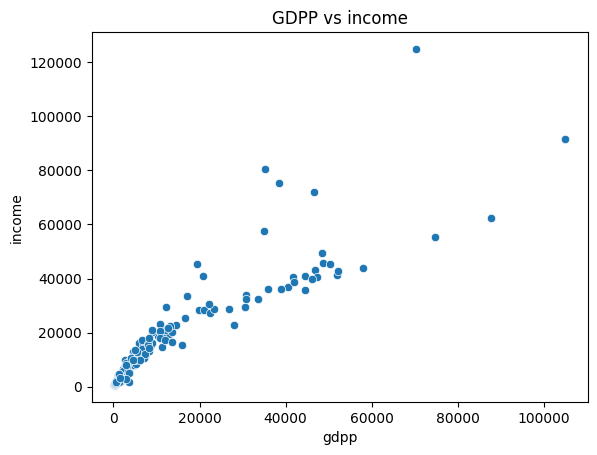

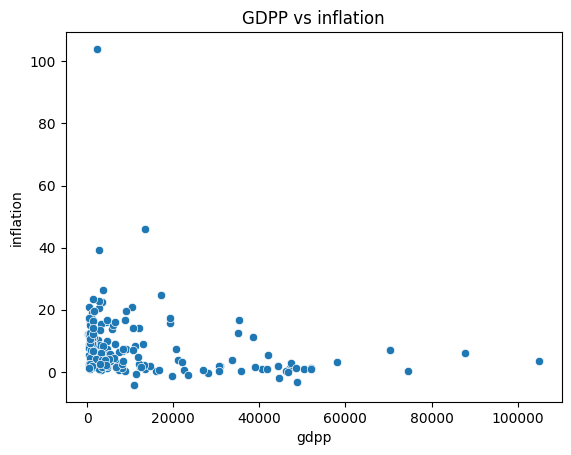

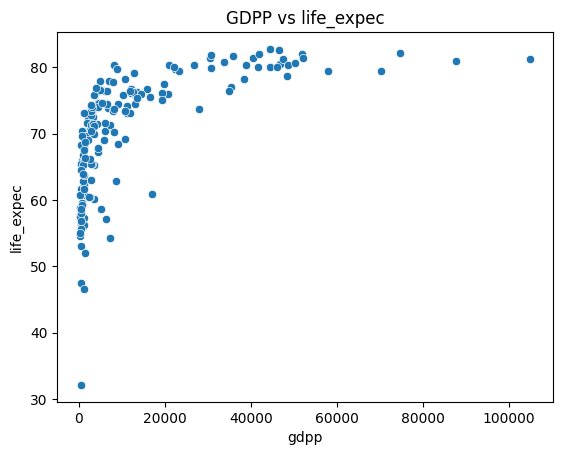

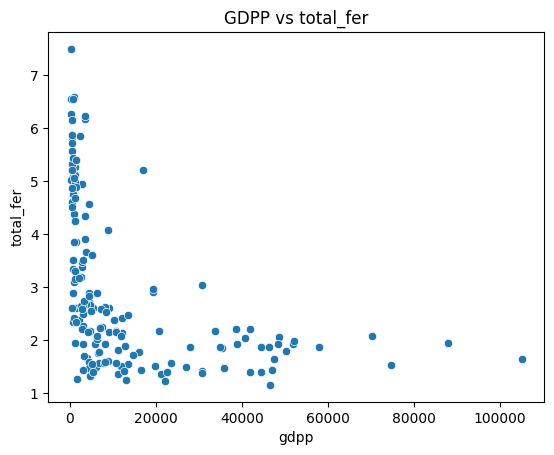

In [ ]:
# Explore the continuous independent features against gdpp using scatter plots.

for column in df_numeric.columns:
    if column != 'gdpp':
        plt.figure()
        sns.scatterplot(data=df_numeric, x='gdpp', y=column)
        plt.title(f'GDPP vs {column}')
        plt.show()

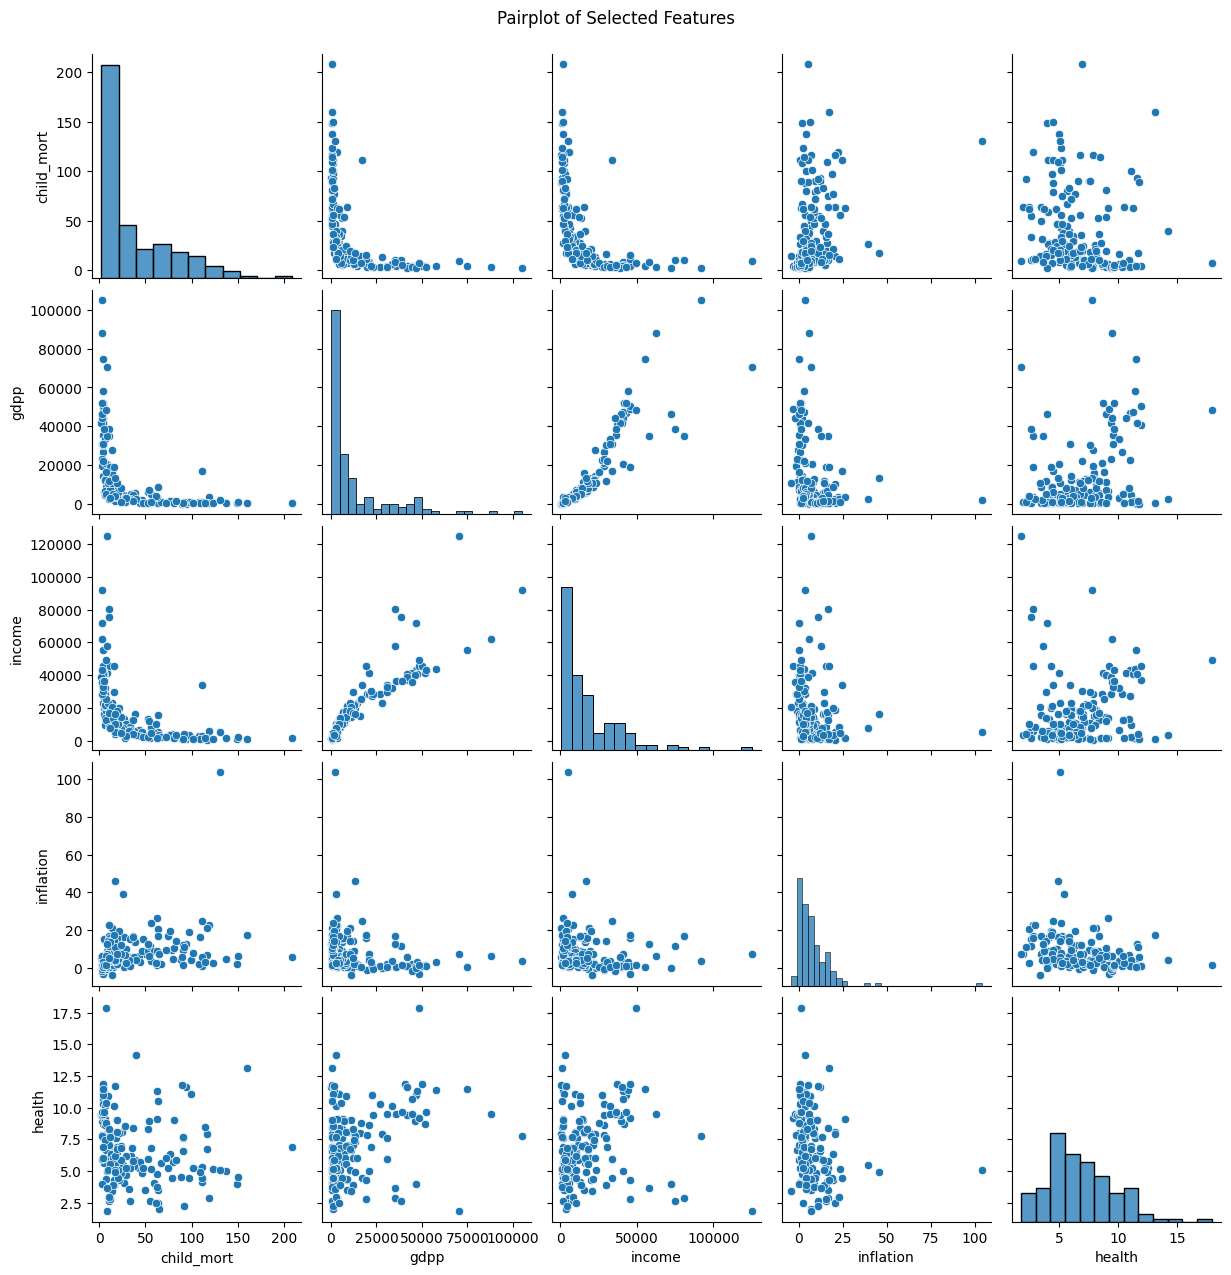

In [ ]:
# Create a pair plot
# Hint: Explore seaborn pairplot

sns.pairplot(df_numeric[['child_mort', 'gdpp', 'income', 'inflation', 'health']])
plt.suptitle("Pairplot of Selected Features", y=1.02)
plt.show()

Note the peaks in the diagonal graphs that are distinct from each other or only overlap slightly. Looking at the scatter plot distributions may also give you some indication of features that would be good candidates for clustering the data.

### Scaling the Data

In [ ]:
# Normalise the data using MinMaxScaler
# Name the normalised dataframe "df_scaled"

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df_numeric)

## K-Means Clustering

### Selecting K

In [ ]:
# Plot elbow curve
def eval_Kmeans(x, k, r):
    kmeans = KMeans(n_clusters=k, random_state=r, max_iter=500)
    kmeans.fit(x)
    return kmeans.inertia_

def elbow_Kmeans(x, max_k=10, r=42):
    within_cluster_vars = [eval_Kmeans(x, k, r) for k in range(1, max_k+1)]
    plt.plot(range(1, 11), within_cluster_vars,marker='o')
    plt.xlabel('K')
    plt.ylabel('Inertia')
    plt.show()

    # Plot elbow curve using scaled dataset

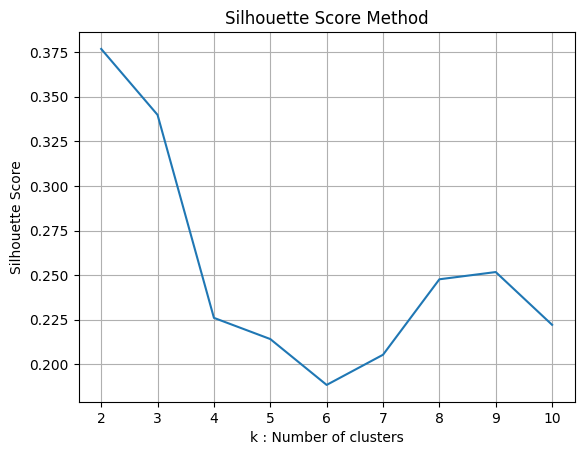

In [ ]:
# Silhouette score method
kmax = 10
sil = []
plt.plot()
for k in range(2, kmax+1):
    kmeans = KMeans(n_clusters=k, random_state=rseed, max_iter=500)
    kmeans.fit(df_scaled)
    labels = kmeans.labels_
    sil.append(silhouette_score(df_scaled, labels, metric='euclidean'))

sns.lineplot(x=range(2, kmax+1), y=sil)
plt.title('Silhouette Score Method')
plt.xlabel('k : Number of clusters')
plt.ylabel("Silhouette Score")
plt.grid(visible=True)
plt.show()

Based on the elbow and silhouette score method choose a value for K.

## Fitting a K-Means Model with the selected K value

In [ ]:
# Remember to set the random_state to rseed

from sklearn.cluster import KMeans

rseed = 42
optimal_k = 3

kmeans = KMeans(n_clusters=optimal_k, random_state=rseed)
df_numeric['cluster'] = kmeans.fit_predict(df_scaled)

In [ ]:
# Count the number of records in each cluster

df_numeric['cluster'].value_counts()

,count
cluster,
0,87
2,45
1,35


In [ ]:
# Check model performance with the silhouette coefficient

from sklearn.metrics import silhouette_score

silhouette = silhouette_score(df_scaled, df_numeric['cluster'])
print("Silhouette Score:", silhouette)

Silhouette Score: 0.33976487765323604


## Predictions

In [ ]:
# Add the predicted cluster label column to the original dataframe

df['cluster'] = df_numeric['cluster']
df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster
0,Afghanistan,90.2,10.0,7.58,44.9,1610.0,9.44,56.2,5.82,553.0,2
1,Albania,16.6,28.0,6.55,48.6,9930.0,4.49,76.3,1.65,4090.0,0
2,Algeria,27.3,38.4,4.17,31.4,12900.0,16.10,76.5,2.89,4460.0,0
3,Angola,119.0,62.3,2.85,42.9,5900.0,22.40,60.1,6.16,3530.0,2
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100.0,1.44,76.8,2.13,12200.0,0


## Visualisation of clusters

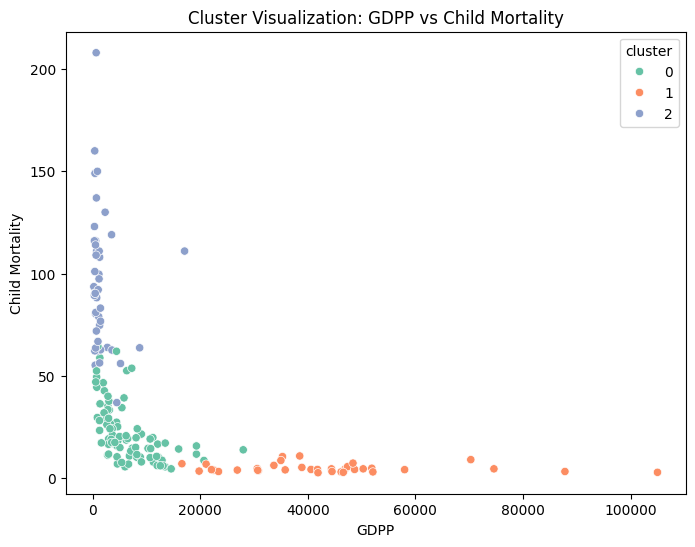

In [ ]:
# Visualisation of clusters: child mortality vs gdpp

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='gdpp', y='child_mort', hue='cluster', palette='Set2')
plt.title("Cluster Visualization: GDPP vs Child Mortality")
plt.xlabel("GDPP")
plt.ylabel("Child Mortality")
plt.show()

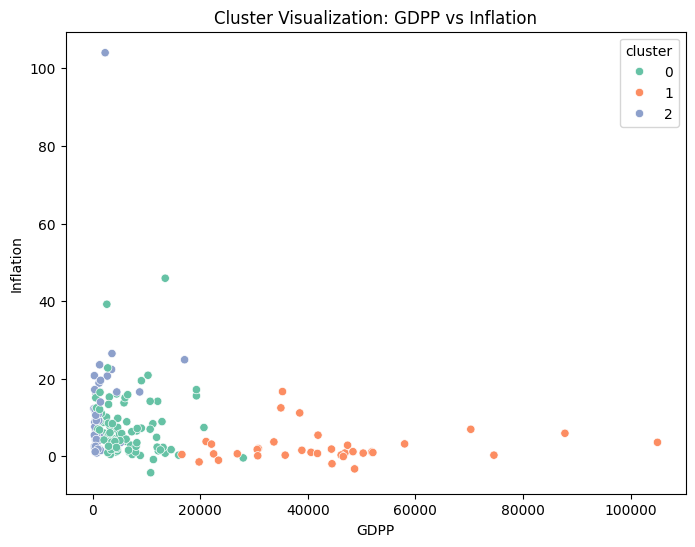

In [ ]:
# Visualisation of clusters: inflation vs gdpp

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='gdpp', y='inflation', hue='cluster', palette='Set2')
plt.title("Cluster Visualization: GDPP vs Inflation")
plt.xlabel("GDPP")
plt.ylabel("Inflation")
plt.show()

## Conclusions

In [ ]:
df.groupby('cluster')[['gdpp', 'child_mort', 'inflation']].mean().sort_values('gdpp', ascending=False)


,gdpp,child_mort,inflation
cluster,,,
1,43117.142857,4.897143,2.535000
0,6657.379310,22.490805,7.599839
2,1704.933333,94.733333,12.214556


Label the groups of countries in the plots you created based on child mortality, GDPP and inflation. You may use [terms](https://en.wikipedia.org/wiki/Developing_country#Terms_used_to_classify_countries) such as: least developed, developing and developed, or low, low-middle, upper-middle and high income. Alternatively, simply rank them from highest to lowest. Justify the labels you assign to each group.


**Answer here:**

Based on the average values, we can label the clusters as follows:
* Cluster 1 represents the developed countries, as it has the highest GDPP (around 43,117), very low child mortality (about 4.9), and low inflation (2.5%). These countries are generally wealthy, healthy, and economically stable.

* Cluster 0 includes the developing countries, with a moderate GDPP (around 6,657), child mortality around 22.5, and inflation at about 7.6%. These countries are in transition, showing signs of growth but still facing some challenges.

* Cluster 2 represents the least developed countries, with very low GDPP (around 1,705), high child mortality (94.7), and high inflation (12.2%). These figures suggest significant struggles with poverty, healthcare, and economic stability.
